In [2]:
from sklearn.datasets import load_boston

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.optim import Adam

import seaborn as sns
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from tensorflow.keras.layers import Dense

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [4]:
boston = load_boston()

/opt/homebrew/Caskroom/miniforge/base/envs/deep_learning/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets

In [5]:
df_data = pd.DataFrame(boston['data'],columns=boston['feature_names'])
df_target = pd.DataFrame(boston['target'],columns=['target'])
df_raw = pd.concat([df_data,df_target],axis=1)
df = df_raw.copy()

In [6]:
df.shape

(506, 14)

<AxesSubplot: >

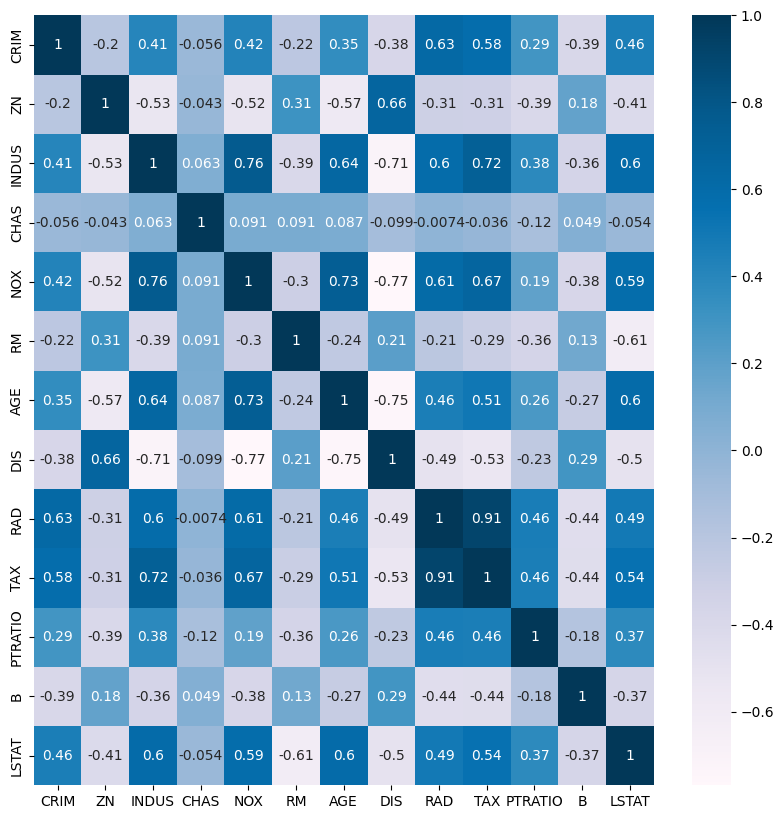

In [7]:
corr_arr=df.iloc[:,:-1].corr()

plt.figure(figsize=(10,10))
sns.heatmap(
    data=corr_arr,
    annot=True,
    cmap=plt.cm.PuBu
)

In [8]:
df.drop(['TAX','AGE','RAD','INDUS'],axis=1,inplace=True)

In [9]:
from sklearn.preprocessing import MinMaxScaler
mms_data = MinMaxScaler()
mms_target = MinMaxScaler()

data_mms=mms_data.fit_transform(df.iloc[:,:-1])
target_mms=mms_target.fit_transform(df.iloc[:,-1].to_numpy().reshape(-1,1))

In [10]:
print(data_mms.shape)
print(target_mms.shape)

(506, 9)
(506, 1)


### Modeling
```
 1. torch_low
 2. torch_high
 3. tf_low
 4. tf_high
 ```

In [10]:
# 1.torch_low

x = torch.FloatTensor(data_mms)
y = torch.FloatTensor(target_mms)

w = torch.empty(9,requires_grad=True)
b = torch.empty(1,requires_grad=True)
torch.nn.init.uniform_(w)
torch.nn.init.uniform_(b)

# cost_function
def cost():
    x_hat = w*x + b
    c = torch.mean( (x_hat-y)**2)
    return c
cost_list = list()
# optimize
optimizer = Adam( [w,b] ,lr=0.01 )
for epoch in range(300):
    c = cost()
    optimizer.zero_grad()
    cost_list.append(c)
    c.backward()
    optimizer.step()
    print('cost', c.item() )


cost 0.5628961324691772
cost 0.5433372855186462
cost 0.5241771340370178
cost 0.5054224729537964
cost 0.48707935214042664
cost 0.46915367245674133
cost 0.4516505002975464
cost 0.43457460403442383
cost 0.41793015599250793
cost 0.40172064304351807
cost 0.38594913482666016
cost 0.3706178069114685
cost 0.35572847723960876
cost 0.3412821888923645
cost 0.3272794187068939
cost 0.3137197196483612
cost 0.3006022572517395
cost 0.2879253625869751
cost 0.27568677067756653
cost 0.263883501291275
cost 0.2525119185447693
cost 0.24156782031059265
cost 0.23104631900787354
cost 0.22094190120697021
cost 0.2112484872341156
cost 0.20195941627025604
cost 0.1930675506591797
cost 0.18456518650054932
cost 0.1764441728591919
cost 0.16869591176509857
cost 0.16131135821342468
cost 0.15428119897842407
cost 0.14759570360183716
cost 0.14124487340450287
cost 0.13521847128868103
cost 0.12950606644153595
cost 0.12409704178571701
cost 0.11898065358400345
cost 0.11414604634046555
cost 0.10958240926265717
cost 0.1052788048

In [11]:
# 예측
temp=df.sample()
temp_data = temp.iloc[:,:-1]
temp_target = temp.iloc[:,-1]

temp_data_mms = mms_data.transform(temp_data)
temp_target_mms = mms_target.transform(temp_target.values.reshape(-1,1))

temp_pred=np.sum((w.detach().numpy()*(temp_data_mms)))+b

print("predict : ",mms_target.inverse_transform(temp_pred.detach().numpy().reshape(-1,1)))
print("actual : ",mms_target.inverse_transform(temp_target_mms))

predict :  [[5.508961]]
actual :  [[10.4]]


In [12]:
preds = np.sum(w.detach().numpy()*data_mms,axis=1) + b.detach().numpy()
r2_score(mms_target.inverse_transform(preds.reshape(-1,1)),mms_target.inverse_transform(target_mms))

0.08655431784436352

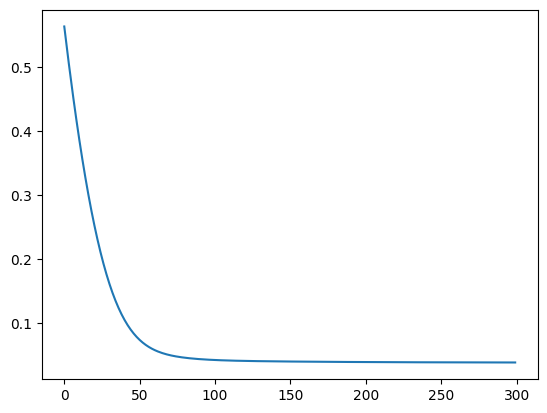

In [13]:
plt.plot([i.detach().numpy() for i in cost_list])

In [14]:
# 2.torch_high

x = torch.FloatTensor(data_mms)
y = torch.FloatTensor(target_mms)

model = torch.nn.Sequential()
model.add_module( 'linear', torch.nn.Linear(9,1) )
loss_fn = torch.nn.MSELoss()

optimizer = Adam( model.parameters(), lr=0.1 )
cost_list = list()

for epoch in range(1000):
    optimizer.zero_grad() # optimizer 초기화
    x_hat = model.forward( x ) # x_hat 계산 
    c = loss_fn( x_hat, y)  # loss 확인
    cost_list.append(c)
    c.backward() # loss 미분
    optimizer.step() # optimizer를 통해 weight 업데이트
    print( 'cost', c.item() )

cost 0.5544646382331848
cost 0.1512030065059662
cost 0.08472679555416107
cost 0.18818776309490204
cost 0.24451082944869995
cost 0.205382838845253
cost 0.12527193129062653
cost 0.06235886365175247
cost 0.045996833592653275
cost 0.06981100887060165
cost 0.10273191332817078
cost 0.11560818552970886
cost 0.10086951404809952
cost 0.07068771123886108
cost 0.04381237179040909
cost 0.03335244208574295
cost 0.04032581299543381
cost 0.054851409047842026
cost 0.06409341096878052
cost 0.06112245097756386
cost 0.048172008246183395
cost 0.03336856886744499
cost 0.024654941633343697
cost 0.0249489713460207
cost 0.031039176508784294
cost 0.036553625017404556
cost 0.03669024631381035
cost 0.031179795041680336
cost 0.02369142323732376
cost 0.018730245530605316
cost 0.018475858494639397
cost 0.021618051454424858
cost 0.024752458557486534
cost 0.02508731186389923
cost 0.022331539541482925
cost 0.018496062606573105
cost 0.016075240448117256
cost 0.01615542732179165
cost 0.01782108098268509
cost 0.019135644

In [15]:
temp=df.sample()
temp_data = temp.iloc[:,:-1]
temp_target = temp.iloc[:,-1]

temp_data_mms = mms_data.transform(temp_data)
temp_target_mms = mms_target.transform(temp_target.values.reshape(-1,1))

temp_pred=np.sum((w.detach().numpy()*(temp_data_mms)))+b

print("predict : ",mms_target.inverse_transform(temp_pred.detach().numpy().reshape(-1,1)))
print("actual : ",mms_target.inverse_transform(temp_target_mms))

predict :  [[22.765865]]
actual :  [[30.7]]


In [16]:
pred = np.sum(w.detach().numpy()*data_mms,axis=1) + b.detach().numpy()
r2_score(mms_target.inverse_transform(preds.reshape(-1,1)),mms_target.inverse_transform(target_mms))

0.08655431784436352

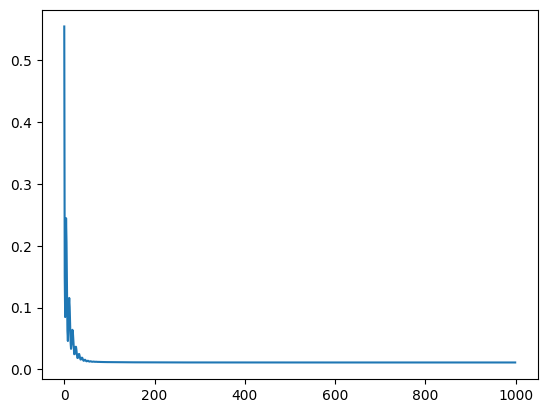

In [17]:
plt.plot([i.detach().numpy() for i in cost_list])

In [18]:
# 3.tf_low
x= tf.constant( data_mms, tf.float32)
y= tf.constant( target_mms, tf.float32)

w = tf.Variable(  tf.random.uniform([9]) )
b = tf.Variable(  tf.random.uniform([1]) )

def cost():
    hx = w*x + b
    c = tf.reduce_mean( (hx-y)**2)
    return c

cost_list = list()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
for i in range(2000):
    optimizer.minimize( cost, var_list = [w,b])
    cost_list.append(cost().numpy())
    print(f'iter_{i+1} : cost : {cost().numpy()}')

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

iter_1 : cost : 0.08650138229131699
iter_2 : cost : 0.08615916222333908
iter_3 : cost : 0.08582890778779984
iter_4 : cost : 0.08551011234521866
iter_5 : cost : 0.08520232886075974
iter_6 : cost : 0.08490511775016785
iter_7 : cost : 0.08461805433034897
iter_8 : cost : 0.08434072136878967
iter_9 : cost : 0.08407274633646011
iter_10 : cost : 0.08381373435258865
iter_11 : cost : 0.08356333523988724
iter_12 : cost : 0.08332119882106781
iter_13 : cost : 0.0830869972705841
iter_14 : cost : 0.08286041021347046
iter_15 : cost : 0.0826411321759224
iter_16 : cost : 0.08242888003587723
iter_17 : cost : 0.08222334831953049
iter_18 : cost : 0.08202429860830307
iter_19 : cost : 0.0818314477801323
iter_20 : cost : 0.08164455741643906
iter_21 : cost : 0.08146338164806366
iter_22 : cost : 0.08128771930932999
iter_23 : cost : 0.08111730217933655
iter_24 : cost : 0.08095196634531021
iter_25 : cost : 0.08079147338867188
iter_2

2022-12-01 09:22:13.710782: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-01 09:22:13.710923: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


iter_35 : cost : 0.07941495627164841
iter_36 : cost : 0.07929671555757523
iter_37 : cost : 0.07918146997690201
iter_38 : cost : 0.07906908541917801
iter_39 : cost : 0.07895947992801666
iter_40 : cost : 0.07885249704122543
iter_41 : cost : 0.07874805480241776
iter_42 : cost : 0.07864607870578766
iter_43 : cost : 0.0785464346408844
iter_44 : cost : 0.0784490555524826
iter_45 : cost : 0.07835383713245392
iter_46 : cost : 0.07826069742441177
iter_47 : cost : 0.0781695544719696
iter_48 : cost : 0.07808034121990204
iter_49 : cost : 0.07799297571182251
iter_50 : cost : 0.07790736854076385
iter_51 : cost : 0.07782349735498428
iter_52 : cost : 0.07774124294519424
iter_53 : cost : 0.07766057550907135
iter_54 : cost : 0.07758142054080963
iter_55 : cost : 0.07750371843576431
iter_56 : cost : 0.07742741703987122
iter_57 : cost : 0.07735246419906616
iter_58 : cost : 0.07727881520986557
iter_59 : cost : 0.07720639556646347
iter_60 : cost : 0.07713518291711807
iter_61 : cost : 0.0770651251077652
iter_

In [19]:
temp=df.sample()
temp_data = temp.iloc[:,:-1]
temp_target = temp.iloc[:,-1]

temp_data_mms = mms_data.transform(temp_data)
temp_target_mms = mms_target.transform(temp_target.values.reshape(-1,1))

temp_pred=np.sum((w.numpy()*(temp_data_mms)))+b

print("predict : ",mms_target.inverse_transform(temp_pred.numpy().reshape(-1,1)))
print("actual : ",mms_target.inverse_transform(temp_target_mms))

predict :  [[44.397022]]
actual :  [[14.5]]


In [20]:
np.array(pred)

array([ 0.47344813,  0.41441341,  0.45096561,  0.46424345,  0.45373414,
        0.44480035,  0.43206861,  0.40343756,  0.34063836,  0.41819093,
        0.40305653,  0.43500665,  0.41183568,  0.37596146,  0.3637581 ,
        0.37091983,  0.3784174 ,  0.33651179,  0.33359779,  0.34603849,
        0.28872936,  0.33762076,  0.31173362,  0.30426099,  0.32946447,
        0.31850996,  0.33838777,  0.31988237,  0.35537945,  0.3574789 ,
        0.28725873,  0.34034252,  0.2517365 ,  0.30388741,  0.28860732,
        0.37396104,  0.36255043,  0.38387347,  0.37651135,  0.6465155 ,
        0.66438883,  0.45212622,  0.4387617 ,  0.43141231,  0.41852711,
        0.4030169 ,  0.38387672,  0.36912507,  0.3004576 ,  0.38160656,
        0.47130563,  0.49442982,  0.52138247,  0.49816088,  0.59429452,
        0.73564666,  0.71306839,  0.76784509,  0.51181023,  0.48748767,
        0.46745335,  0.45806078,  0.51077163,  0.5088168 ,  0.52878545,
        0.68379825,  0.64808346,  0.46832432,  0.43810009,  0.46

In [21]:
preds = np.sum(w.numpy()*data_mms,axis=1) + b
r2_score(mms_target.inverse_transform(np.array(pred).reshape(-1,1)),mms_target.inverse_transform(target_mms))

0.08655431784436352

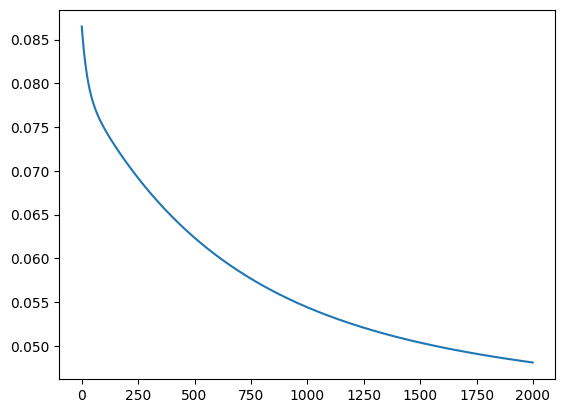

In [22]:
plt.plot(cost_list)

In [13]:
# 4.tf_high

from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential

x= tf.constant( data_mms, tf.float32)
y= tf.constant( target_mms, tf.float32)

dense = Dense(units=1, input_dim=9)
model = Sequential([dense])
model.compile(loss='mse',optimizer=Adam(lr=0.1))
h = model.fit(x,y,epochs=500,verbose=0)

Epoch 1/500


/opt/homebrew/Caskroom/miniforge/base/envs/deep_learning/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2022-12-01 09:35:10.591378: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-01 09:35:10.726459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 4ms/step - loss: 0.2857
Epoch 2/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0785
Epoch 3/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0336
Epoch 4/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0178
Epoch 5/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0136
Epoch 6/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0133
Epoch 7/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0123
Epoch 8/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0119
Epoch 9/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0119
Epoch 10/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0119
Epoch 11/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0121
Epoch 12/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0121
Epoch 13/500
16/16 [=============================

In [15]:
temp=df.sample()
pred=model.predict(temp.iloc[:,:-1])

1/1 [==============================] - 0s 55ms/step


2022-12-01 09:38:14.324801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [25]:
w,b = dense.get_weights()
preds = model.predict(x)
r2_score(preds,mms_target)

0.08655431784436352

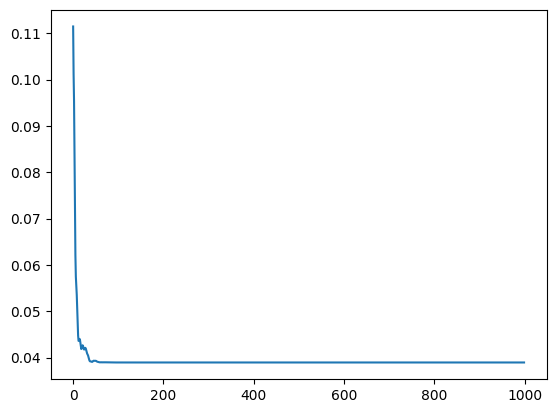

In [26]:
plt.plot(cost_list)